<a href="https://colab.research.google.com/github/threedee003/MineralProspectivityMapping/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
trainDir = "/content/drive/MyDrive/GIS/trainTiles"
testDir = "/content/drive/MyDrive/GIS/testTiles"

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io as io
import time
from itertools import product



import torch.nn as nn
import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset
from torchvision.transforms import transforms
import torch.nn.functional as F

In [4]:

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform1 = None, transform2 = None):
        self.data_dir = data_dir
        self.transform1 = transform1
        self.transform2 = transform2
        self.imageFilenames = sorted(os.listdir(os.path.join(data_dir, "tiles")))

    def __len__(self):
        return len(self.imageFilenames)

    def __getitem__(self, idx):
        imagePath = os.path.join(self.data_dir, "tiles", self.imageFilenames[idx])
        img = np.load(imagePath)
        X = img[:,:,0:5]
        if np.unique(img[:,:,-1]).shape[0] == 2:
          Y = np.array(1)
        else:
          Y = np.array(0)
        Y = np.reshape(Y,(1,1))
        #Y = img[:,:,-1]


        

        if self.transform1:
            X = self.transform1(X)
        
        if self.transform2:
          Y = self.transform2(Y)

        return X, Y


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,0.5,0.5), (0.5,0.5,0.5, 0.5, 0.5))
])
transform2 = transforms.Compose([
    transforms.ToTensor(),
])

In [12]:
trainSet = CustomDataset(trainDir, transform1 = transform,transform2 = transform2)
validationSet = CustomDataset(testDir, transform1 = transform, transform2 = transform2)

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True)
validationLoader = torch.utils.data.DataLoader(validationSet, batch_size = 32, shuffle = True)

In [13]:
print("Number of training samples : {}".format(len(trainLoader)))
print("Number of validating samples : {}".format(len(validationLoader)))

Number of training samples : 35
Number of validating samples : 14


In [14]:
for i,j in trainLoader:
  print(j.resize_(1))
  print(j)
  break

tensor([0])
tensor([0])


In [15]:
class AlexNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(5, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        logits = self.classifier(x)
        return F.log_softmax(logits,dim = 1)

In [16]:
cnn1 = AlexNet(2)

In [17]:
summary(cnn1.to('cuda'),(5,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          38,784
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

In [22]:
def train(model, trainLoader, validationLoader, lossFn, optimizer, epochs, device, trainLosses, valLosses, trainACC, valACC):
  startTime = time.time()

  print("Training has begun.....")
  model = model.to(device)
  for epoch in range(epochs):
    trainingLoss = 0
    trainCorr = 0
    totals = 0
    model.train()
    for img,target in trainLoader:
      target = target.resize_(target.size(0))
      optimizer.zero_grad()
      img = img.to(device)
      target = target.to(device)
      pred = model(img)
      loss = lossFn(pred,target)
      loss.backward()
      optimizer.step()
      trainingLoss += loss.item()*target.size(0)
      totals += target.size(0)
      predicted = torch.argmax(pred,1)
      trainCorr += (predicted == target).sum().item()


    validationLoss = 0
    validationCorr = 0
    total = 0
    with torch.no_grad():
      for img, target in validationLoader:
        target = target.resize_(target.size(0))
        img = img.to(device)
        target = target.to(device)
        pred = model(img)
        loss = lossFn(pred,target)
        validationLoss += loss.item()*target.size(0)
        totals += target.size(0)
        predicted = torch.argmax(pred,1)
        validationCorr += (predicted == target).sum().item()

    
    trainAcc = trainCorr/totals*100
    valAcc = validationCorr/totals*100
    trainLoss = trainingLoss/totals*100
    validLoss = validationLoss/totals*100
    trainLosses.append(trainLoss)
    trainACC.append(trainAcc)
    valLosses.append(validLoss)
    valACC.append(valAcc)

    print(f"Epoch : {epoch+1}/{epochs}.....Training Loss :{trainLoss}; Training Accuracy :{trainAcc}; Validation Loss :{validLoss}; Validation Accuracy :{valAcc} ")
  print(f"Training is complete...")
  print("--%s seconds" %(time.time()-startTime))







In [23]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(cnn1.parameters(), lr=0.001)
batchSize = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 50
trainArr = []
validArr = []
trainACC = []
validACC = []

In [24]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.2 GB
Cached:    0.2 GB


In [25]:
train(cnn1,trainLoader,validationLoader,criterion,optimizer,eps,device,trainArr,validArr,trainACC,validACC)

Training has begun.....
Epoch : 1/50.....Training Loss :21.9842463827286; Training Accuracy :68.14102564102565; Validation Loss :7.405602985467666; Validation Accuracy :26.794871794871796 
Epoch : 2/50.....Training Loss :25.97053892337359; Training Accuracy :68.14102564102565; Validation Loss :16.725528521988636; Validation Accuracy :26.794871794871796 
Epoch : 3/50.....Training Loss :15.8134219623529; Training Accuracy :68.14102564102565; Validation Loss :9.193133757664606; Validation Accuracy :26.794871794871796 
Epoch : 4/50.....Training Loss :16.87156816323598; Training Accuracy :68.14102564102565; Validation Loss :12.483259638150534; Validation Accuracy :26.794871794871796 
Epoch : 5/50.....Training Loss :16.045763110503174; Training Accuracy :68.14102564102565; Validation Loss :22.609132551229916; Validation Accuracy :26.794871794871796 
Epoch : 6/50.....Training Loss :13.91646766509765; Training Accuracy :68.14102564102565; Validation Loss :15.226411934082323; Validation Accurac

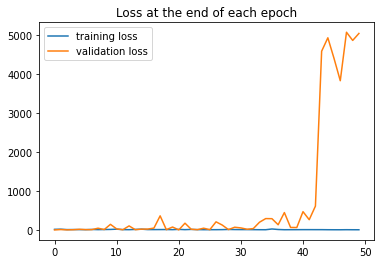

In [26]:

plt.plot(trainArr, label='training loss')
plt.plot(validArr, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();